From the paper:
"Patches Are All You Need?"
by Asher Trockman, J. Zico Kolter1

published in Transactions on Machine Learning Research (03/2023)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np 

In [3]:
device = torch.device('mps')

transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    '~/ML/data/', 
    train=True, 
    download=True,
    transform=transform,
)
train_dataset.data.to(device)
train_dataset.targets.to(device)


test_dataset = torchvision.datasets.MNIST(
    '~/ML/data/',
    train=False,
    download=True,
    transform=transform
)
test_dataset.data.to(device)
test_dataset.targets.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True 
)

In [4]:
# From Patches Are All You Need? paper

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) +x
    
def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                nn.GELU(),
                nn.BatchNorm2d(dim)
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)), 
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [5]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        input_dim = 28
        kernel_size = 5
        self.net = ConvMixer(100, 2, kernel_size=5, patch_size=3, n_classes=10)
        
    def forward(self, x):
        x = self.net(x)
        return F.log_softmax(x, dim =1)
    
network = MNISTNet().to(device)
optimizer = optim.Adam(network.parameters())

In [6]:
train_log_batch = 100
def train(epoch):
    network.train()
    total_loss = 0
    total_correct = 0
    count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_correct += (target == output.data.max(1).indices).sum()
        count+=target.shape[0]

        if (batch_idx+1) % train_log_batch == 0:
            print("\tTrain Batch: {} Loss: {:.6f}".format(batch_idx+1, total_loss/count))
            
    print('Train Epoch: {} Accuracy: {:.4f}% Loss: {:.6f}\n'.format(epoch, total_correct/count*100, total_loss/count))


In [7]:
bad_samples = []
def test():
    network.eval() 
    total_loss = 0
    total_correct = 0
    count = 0
    bad_samples = []
    for batch_idx, (data, target) in enumerate(test_loader):
        target=target.to(device)
        output = network(data.to(device))
        loss = F.nll_loss(output, target)
        total_loss += loss.item()
        
        pred = output.data.max(1).indices
        total_correct += (pred == target).sum()
        count+=target.shape[0]
        
    print('Test Accuracy: {:.4f}, Loss: {:.6f}\n'.format(total_correct/count*100 , total_loss/count))

In [8]:
import timeit
timeit.timeit(lambda: test(), number=1 )

Test Accuracy: 9.9300, Loss: 0.002266



3.471329459000117

In [9]:
n_epoch=8
test()
for epoch in range(1, n_epoch+1):
    train(epoch)
    test()

Test Accuracy: 9.9300, Loss: 0.002266



	Train Batch: 100 Loss: 0.020088


	Train Batch: 200 Loss: 0.012534


	Train Batch: 300 Loss: 0.009318


	Train Batch: 400 Loss: 0.007594


	Train Batch: 500 Loss: 0.006513


	Train Batch: 600 Loss: 0.005702


	Train Batch: 700 Loss: 0.005121


	Train Batch: 800 Loss: 0.004669


	Train Batch: 900 Loss: 0.004305


Train Epoch: 1 Accuracy: 92.5617% Loss: 0.004191



Test Accuracy: 98.0367, Loss: 0.000067



	Train Batch: 100 Loss: 0.001016


	Train Batch: 200 Loss: 0.001012


	Train Batch: 300 Loss: 0.000985


	Train Batch: 400 Loss: 0.000989


	Train Batch: 500 Loss: 0.000970


	Train Batch: 600 Loss: 0.000976


	Train Batch: 700 Loss: 0.000985


	Train Batch: 800 Loss: 0.000963


	Train Batch: 900 Loss: 0.000965


Train Epoch: 2 Accuracy: 98.1283% Loss: 0.000964



Test Accuracy: 98.6883, Loss: 0.000043



	Train Batch: 100 Loss: 0.000719


	Train Batch: 200 Loss: 0.000712


	Train Batch: 300 Loss: 0.000702


	Train Batch: 400 Loss: 0.000675


	Train Batch: 500 Loss: 0.000674


	Train Batch: 600 Loss: 0.000673


	Train Batch: 700 Loss: 0.000692


	Train Batch: 800 Loss: 0.000690


	Train Batch: 900 Loss: 0.000695


Train Epoch: 3 Accuracy: 98.6017% Loss: 0.000694



Test Accuracy: 99.2233, Loss: 0.000026



	Train Batch: 100 Loss: 0.000435


	Train Batch: 200 Loss: 0.000464


	Train Batch: 300 Loss: 0.000462


	Train Batch: 400 Loss: 0.000485


	Train Batch: 500 Loss: 0.000511


	Train Batch: 600 Loss: 0.000512


	Train Batch: 700 Loss: 0.000513


	Train Batch: 800 Loss: 0.000526


	Train Batch: 900 Loss: 0.000528


Train Epoch: 4 Accuracy: 98.9167% Loss: 0.000529



Test Accuracy: 99.1917, Loss: 0.000026



	Train Batch: 100 Loss: 0.000309


	Train Batch: 200 Loss: 0.000380


	Train Batch: 300 Loss: 0.000378


	Train Batch: 400 Loss: 0.000396


	Train Batch: 500 Loss: 0.000404


	Train Batch: 600 Loss: 0.000417


	Train Batch: 700 Loss: 0.000417


	Train Batch: 800 Loss: 0.000436


	Train Batch: 900 Loss: 0.000446


Train Epoch: 5 Accuracy: 99.0717% Loss: 0.000449



Test Accuracy: 99.5800, Loss: 0.000015



	Train Batch: 100 Loss: 0.000315


	Train Batch: 200 Loss: 0.000311


	Train Batch: 300 Loss: 0.000318


	Train Batch: 400 Loss: 0.000334


	Train Batch: 500 Loss: 0.000338


	Train Batch: 600 Loss: 0.000349


	Train Batch: 700 Loss: 0.000348


	Train Batch: 800 Loss: 0.000356


	Train Batch: 900 Loss: 0.000366


Train Epoch: 6 Accuracy: 99.2383% Loss: 0.000371



Test Accuracy: 99.6667, Loss: 0.000012



	Train Batch: 100 Loss: 0.000335


	Train Batch: 200 Loss: 0.000289


	Train Batch: 300 Loss: 0.000288


	Train Batch: 400 Loss: 0.000300


	Train Batch: 500 Loss: 0.000297


	Train Batch: 600 Loss: 0.000306


	Train Batch: 700 Loss: 0.000300


	Train Batch: 800 Loss: 0.000296


	Train Batch: 900 Loss: 0.000300


Train Epoch: 7 Accuracy: 99.3883% Loss: 0.000301



Test Accuracy: 99.6100, Loss: 0.000012



	Train Batch: 100 Loss: 0.000264


	Train Batch: 200 Loss: 0.000248


	Train Batch: 300 Loss: 0.000253


	Train Batch: 400 Loss: 0.000256


	Train Batch: 500 Loss: 0.000260


	Train Batch: 600 Loss: 0.000260


	Train Batch: 700 Loss: 0.000265


	Train Batch: 800 Loss: 0.000276


	Train Batch: 900 Loss: 0.000279


Train Epoch: 8 Accuracy: 99.4133% Loss: 0.000281



Test Accuracy: 99.7017, Loss: 0.000009



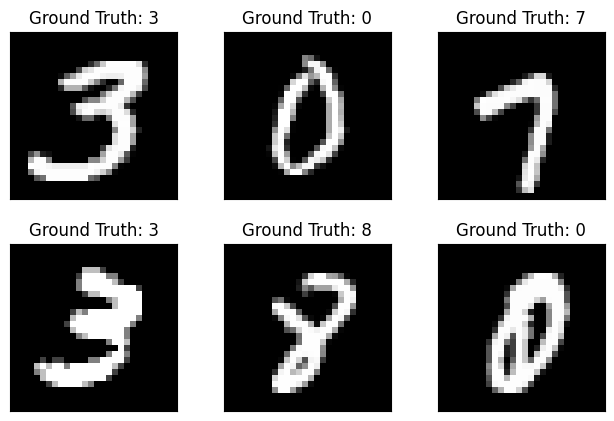

In [10]:
import matplotlib.pyplot as plt

def plotImages(n, data, targets, pred=None):
    fig = plt.figure()
    ncols = 3
    nrows = n//ncols
    for i in range(n):
      plt.subplot(nrows, ncols,i+1)
      plt.tight_layout()
      plt.imshow(data[i][0], cmap='gray', interpolation='none')
      if pred != None:
        plt.title("Ground Truth: {}| Pred:{}".format(targets[i], pred[i]))
      else:
        plt.title("Ground Truth: {}".format(targets[i]))
      plt.xticks([])
      plt.yticks([])
      fig

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
plotImages(6, example_data, example_targets)

In [12]:
def find_bad_samples(n):
    network.eval() 
    count = 0
    bad_samples = []
    bad_samples_target = []
    predictions = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = network(data)

        pred = output.data.max(1).indices
        idxs = pred != (target.to(device))
        
        bad_samples+=data[idxs].tolist()
        bad_samples_target+=target[idxs].tolist()
        predictions+=pred[idxs].tolist()
        
        count+=idxs.sum()
        if (count >= n):
            break
    
    return bad_samples, bad_samples_target, predictions


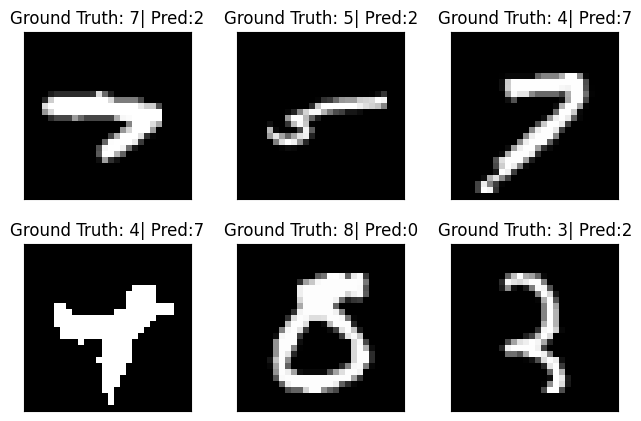

In [36]:
n = 6
data, targets, predictions = find_bad_samples(n)
plotImages(n, data, targets, predictions)